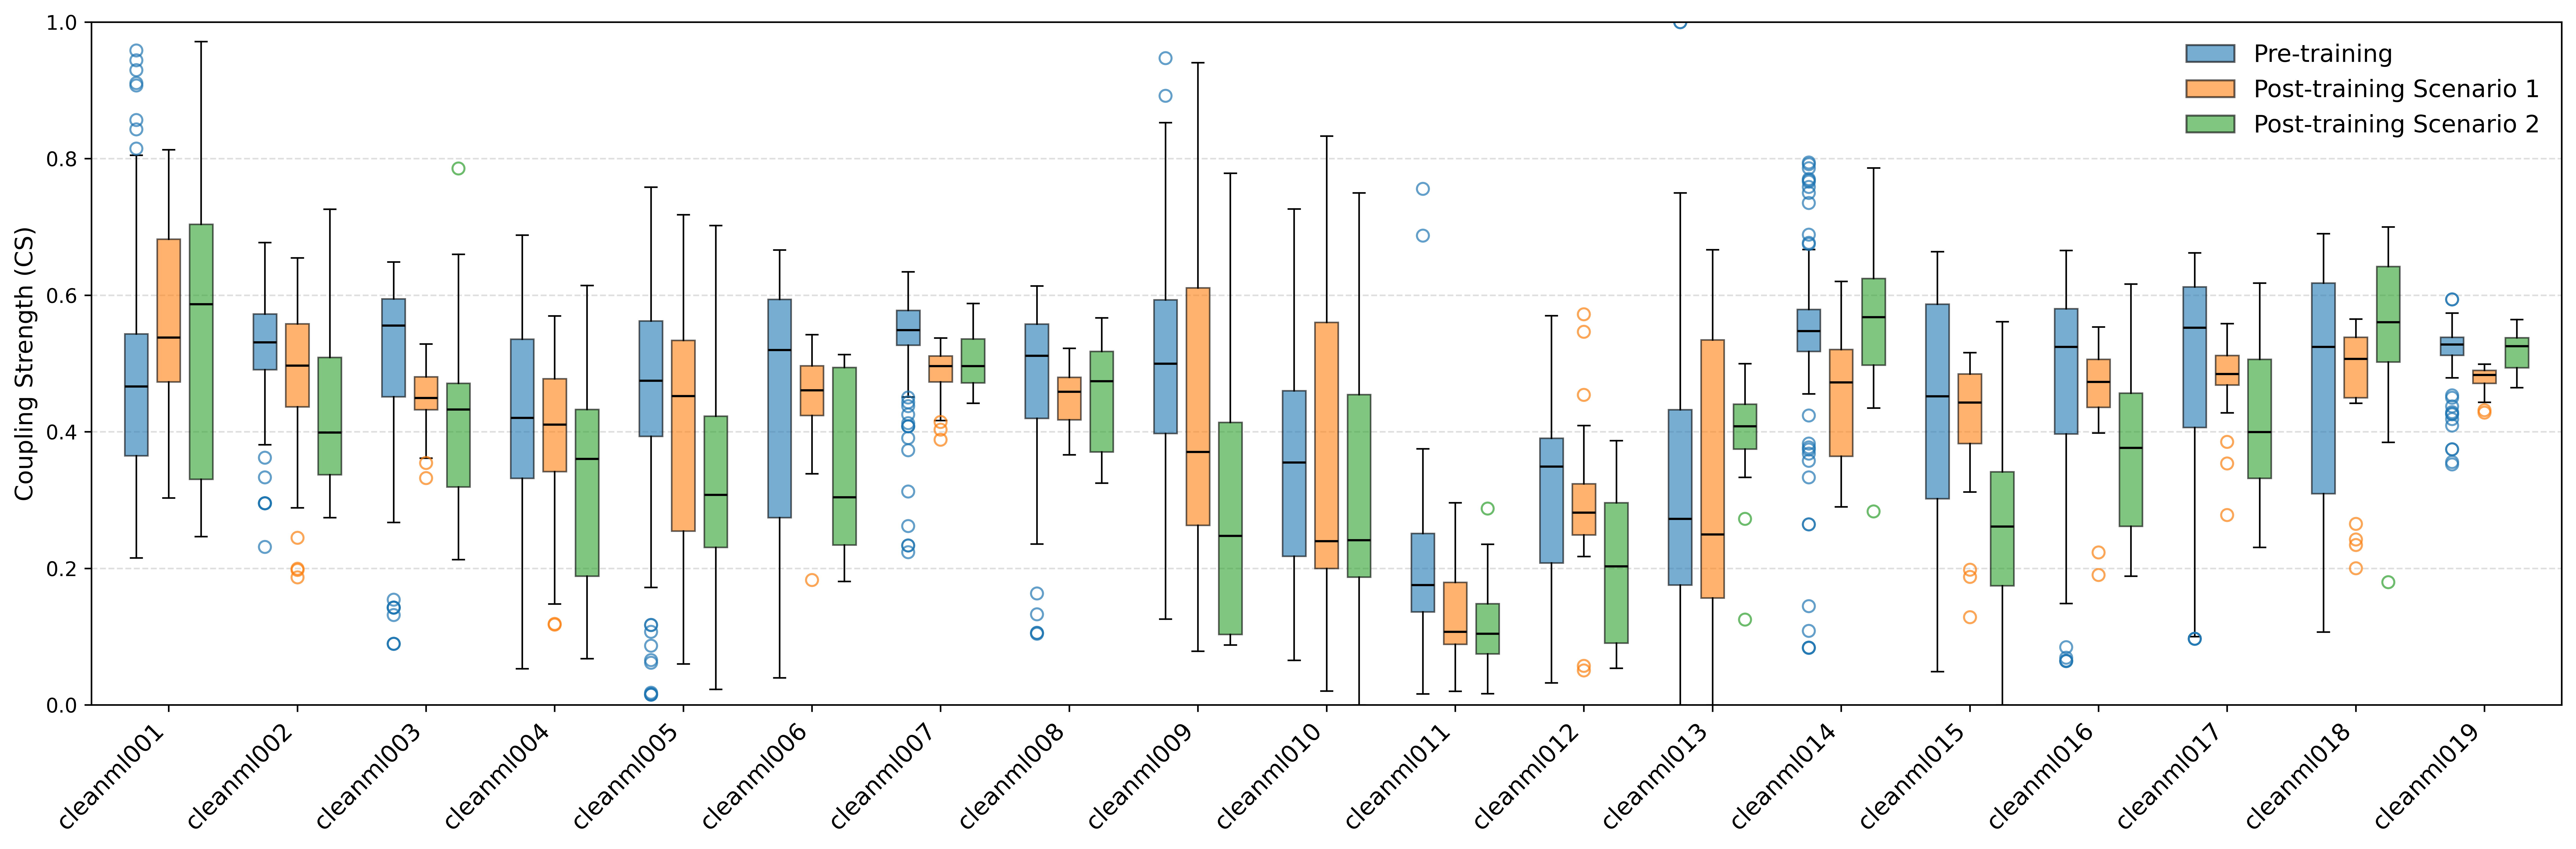

Saved: figures\coupling_strength\cleanml_coupling_strength.pdf


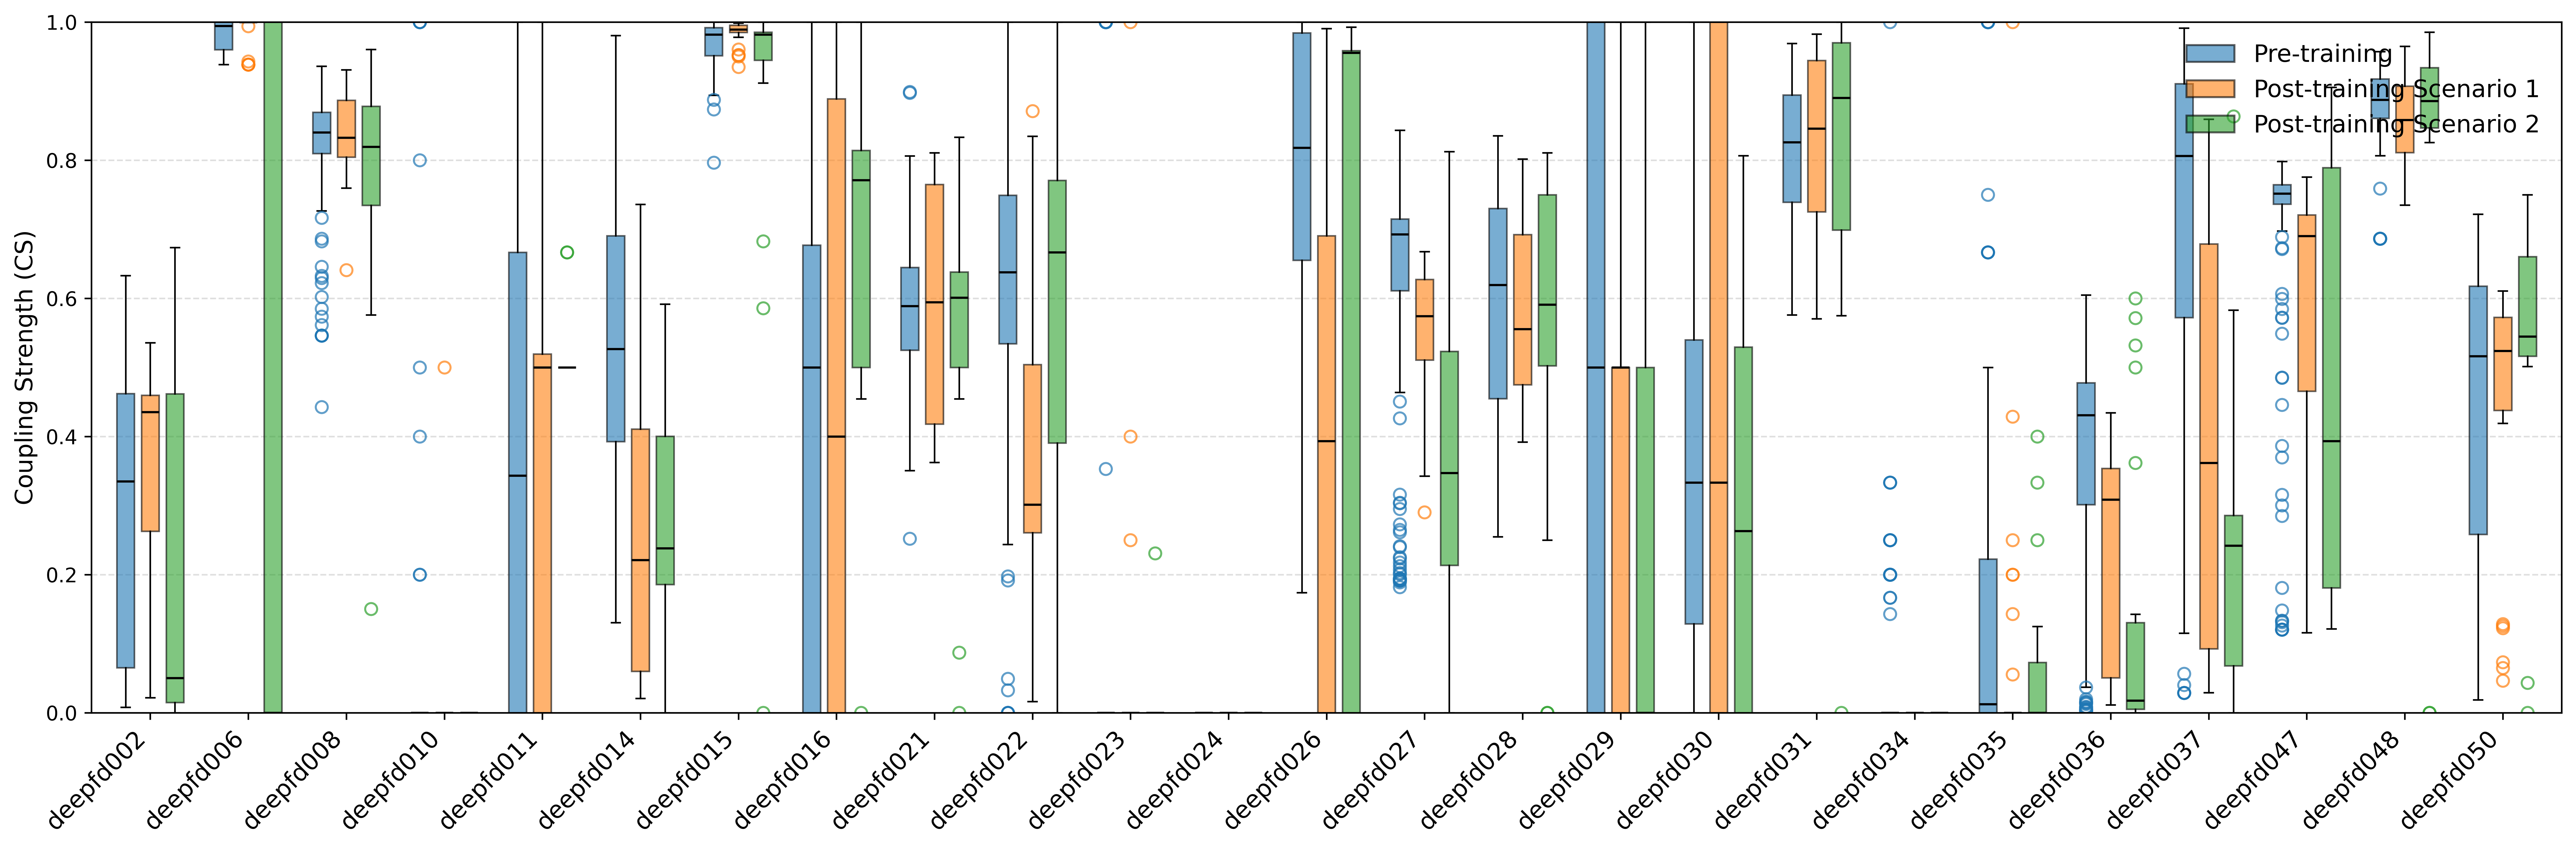

Saved: figures\coupling_strength\deepfd_coupling_strength.pdf


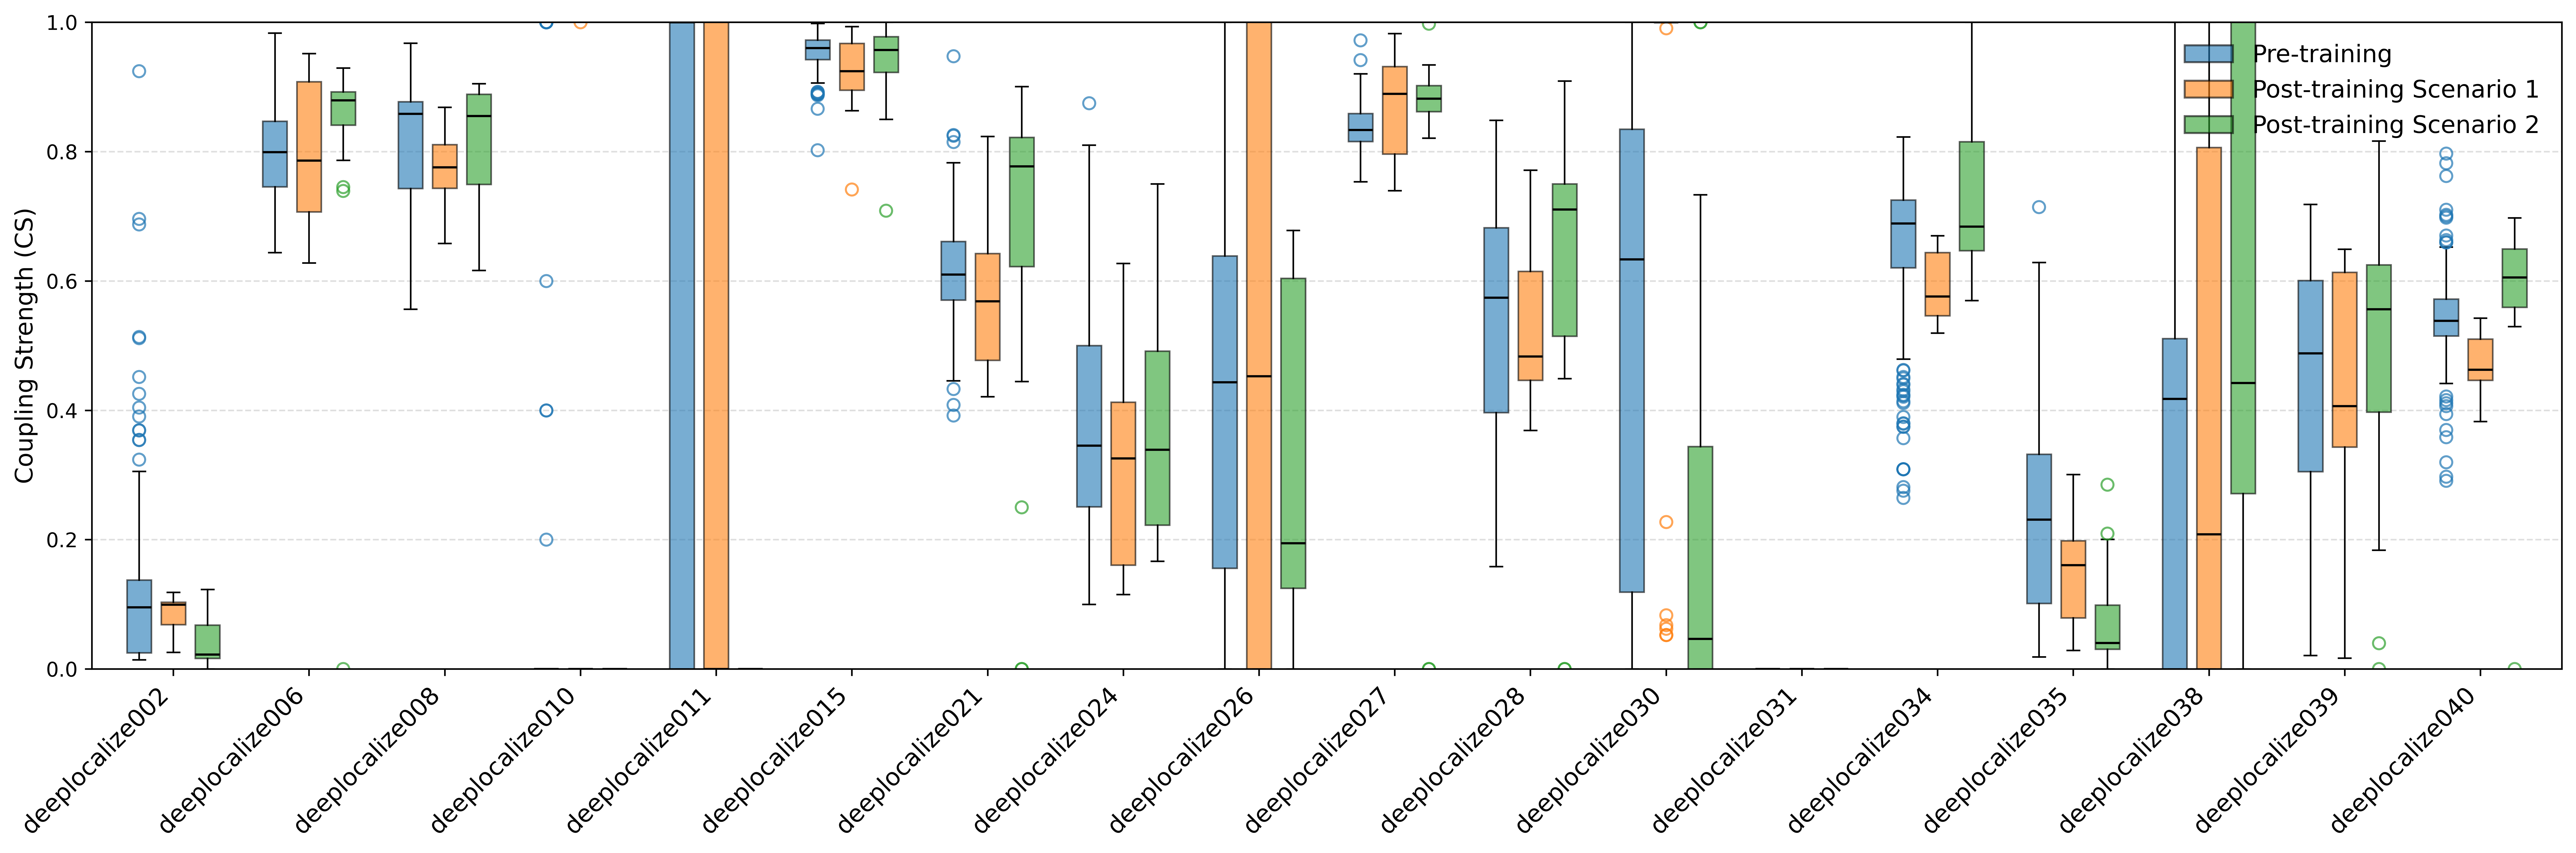

Saved: figures\coupling_strength\deeplocalize_coupling_strength.pdf


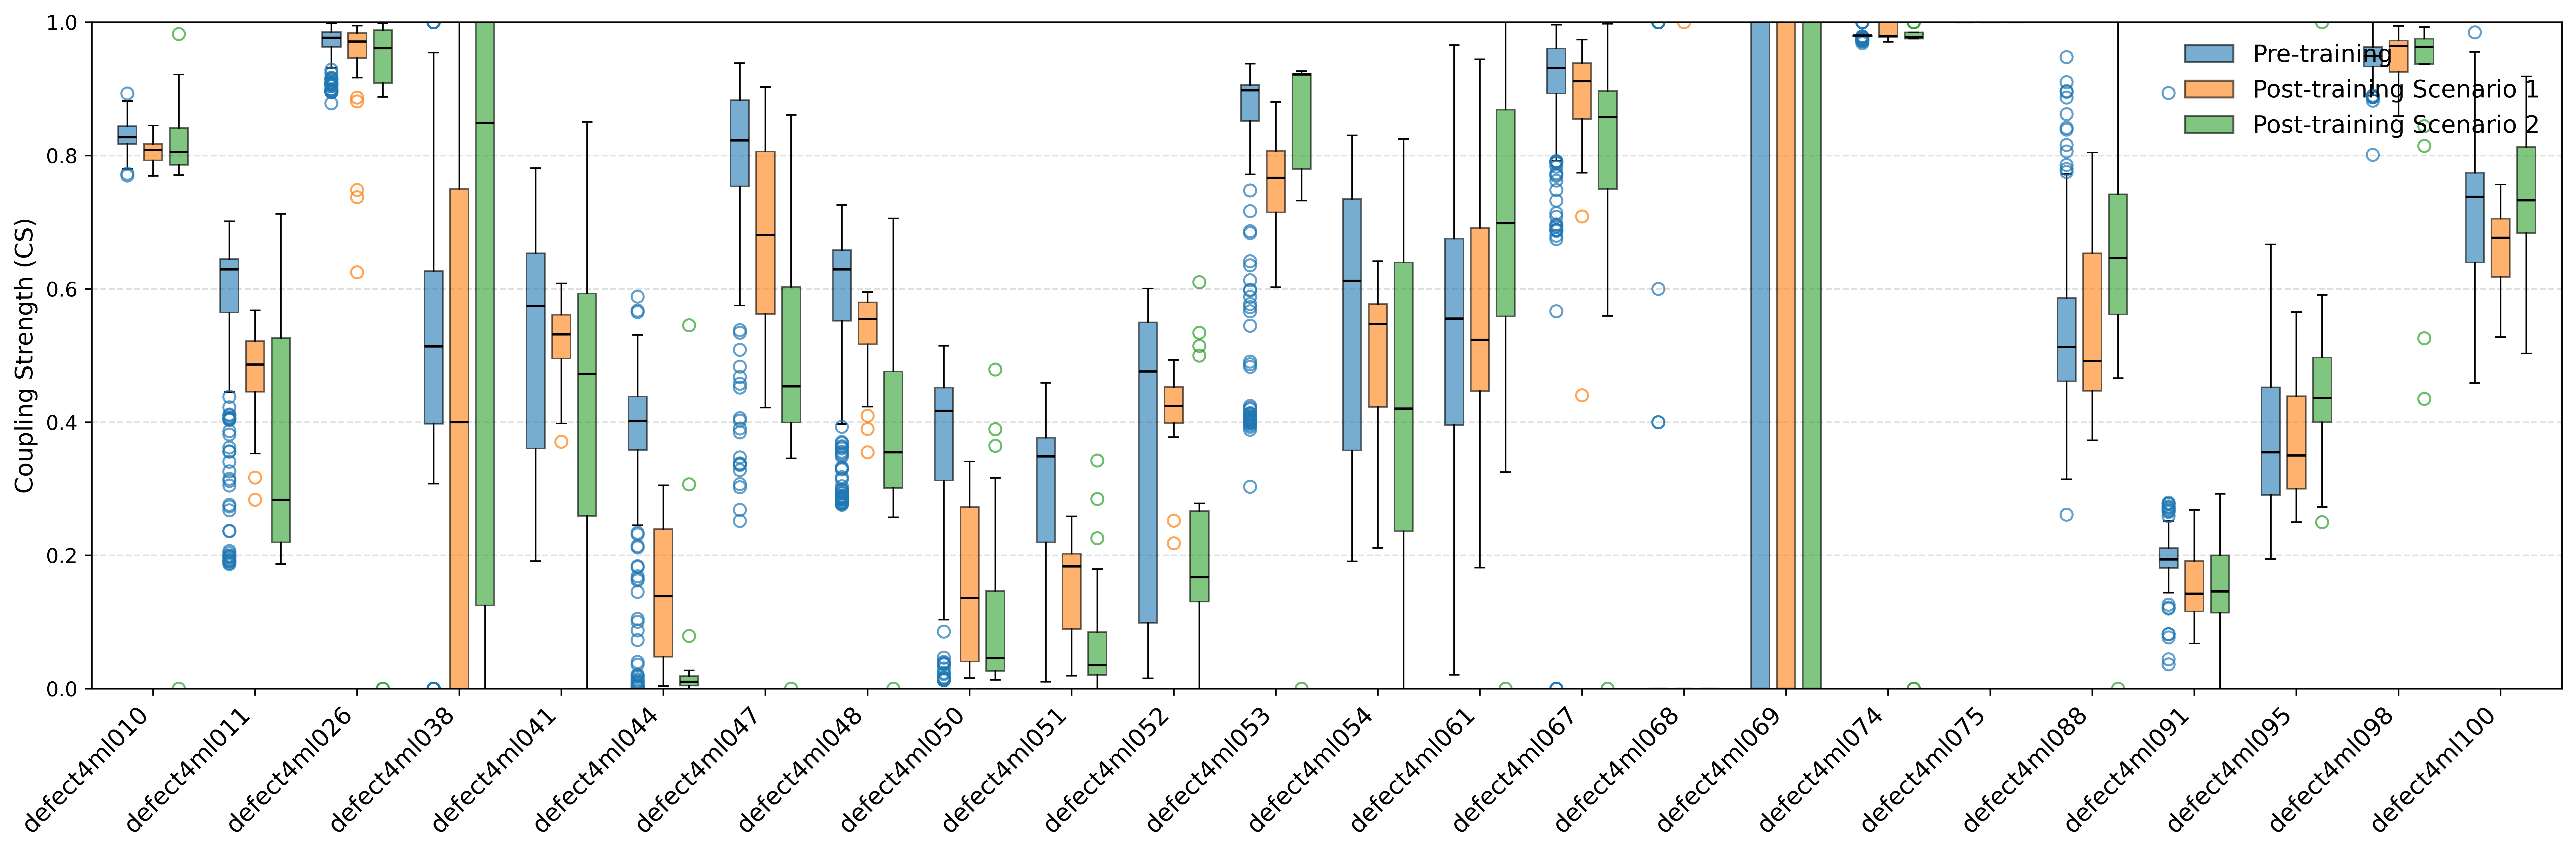

Saved: figures\coupling_strength\defect4ml_coupling_strength.pdf


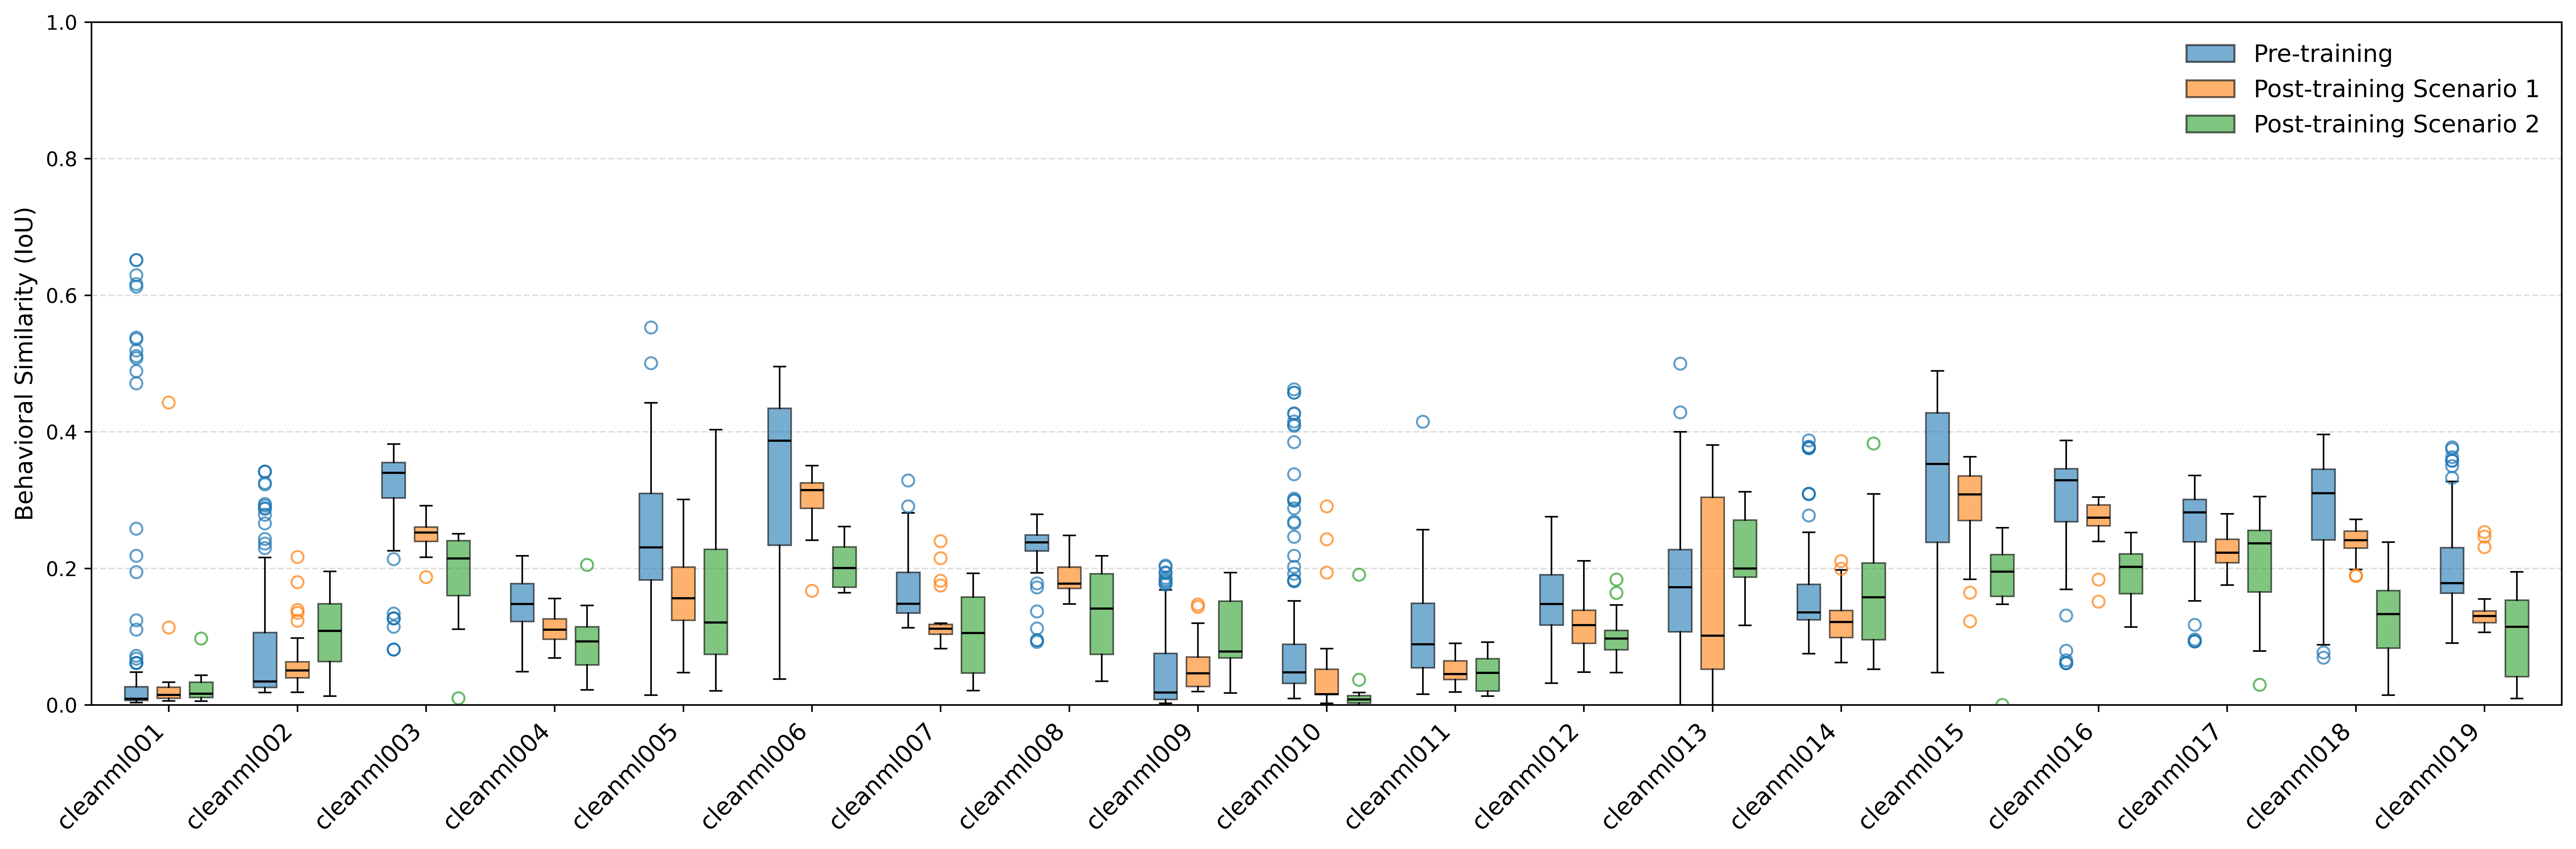

Saved: figures\iou\cleanml_iou.pdf


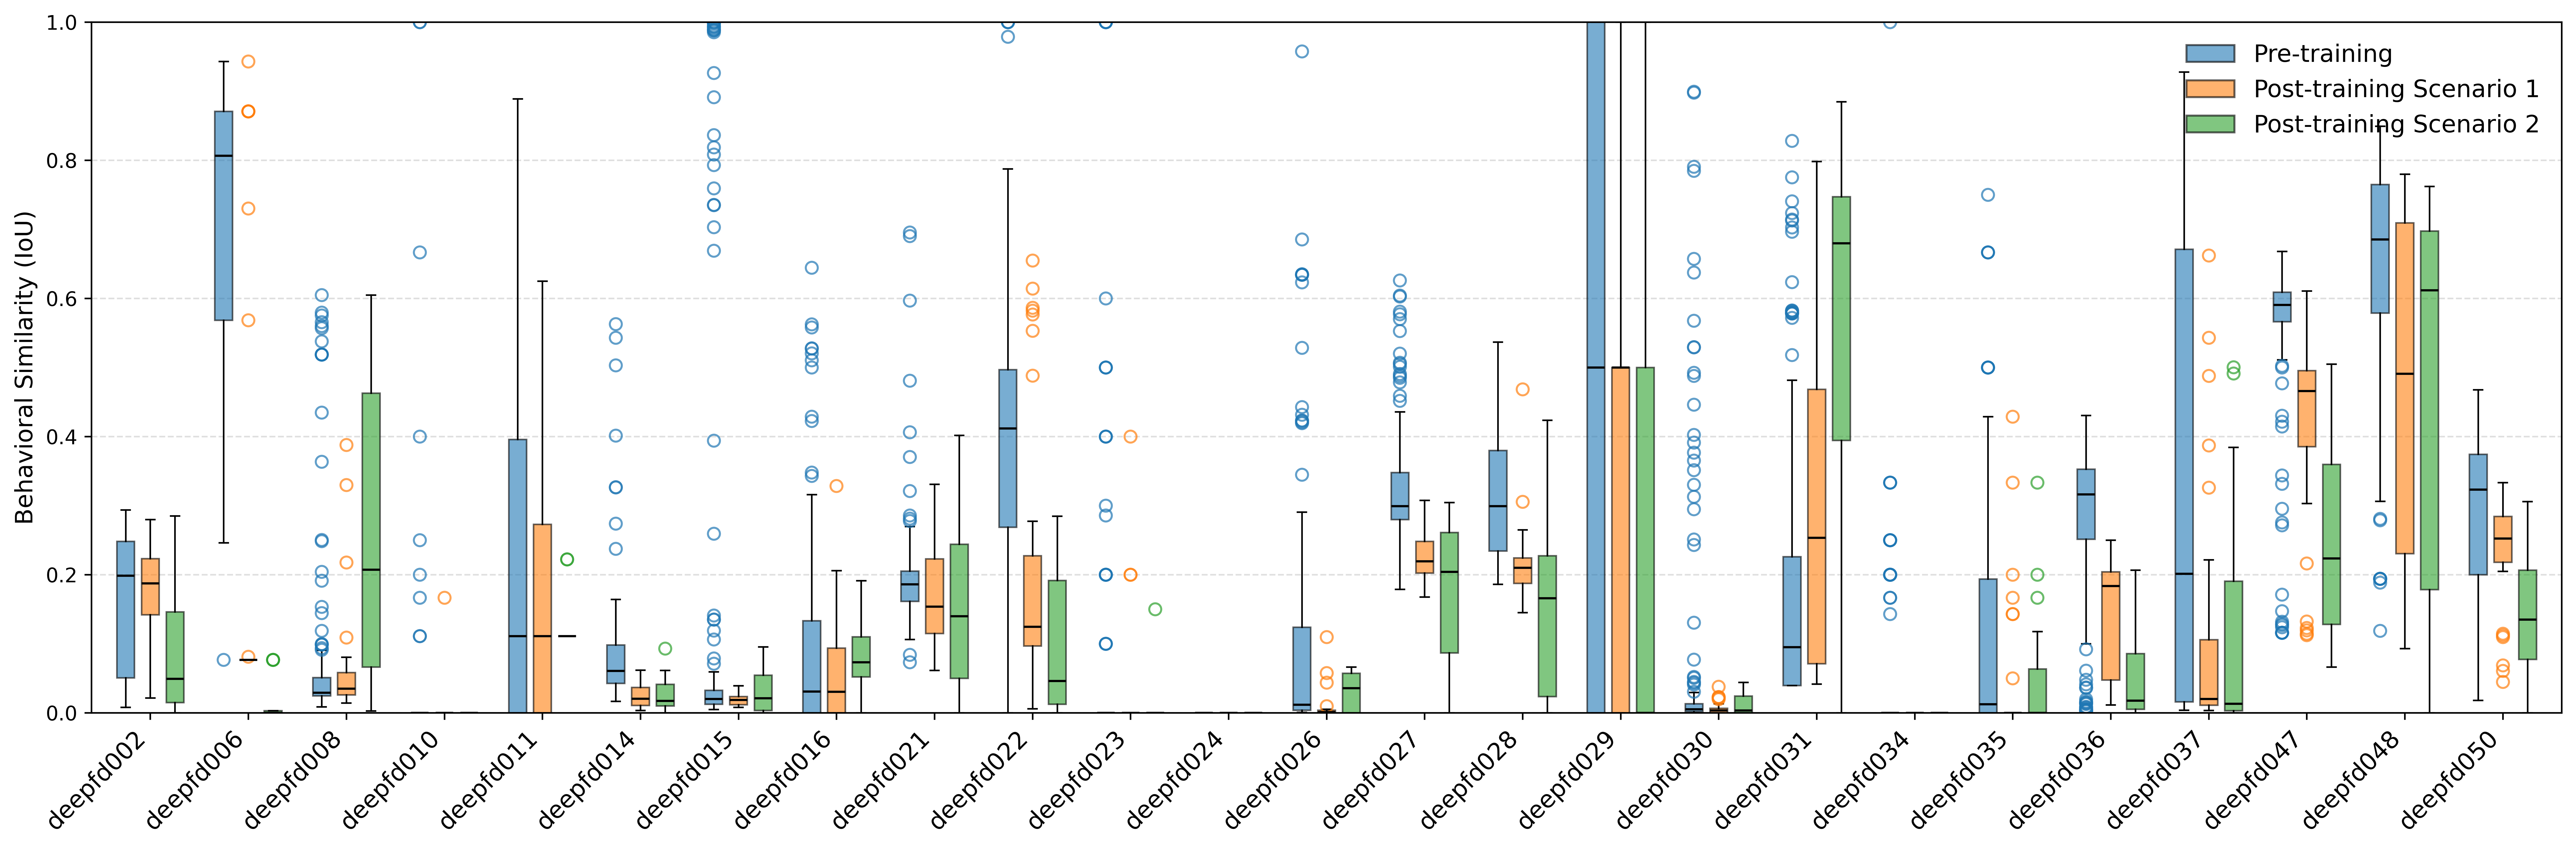

Saved: figures\iou\deepfd_iou.pdf


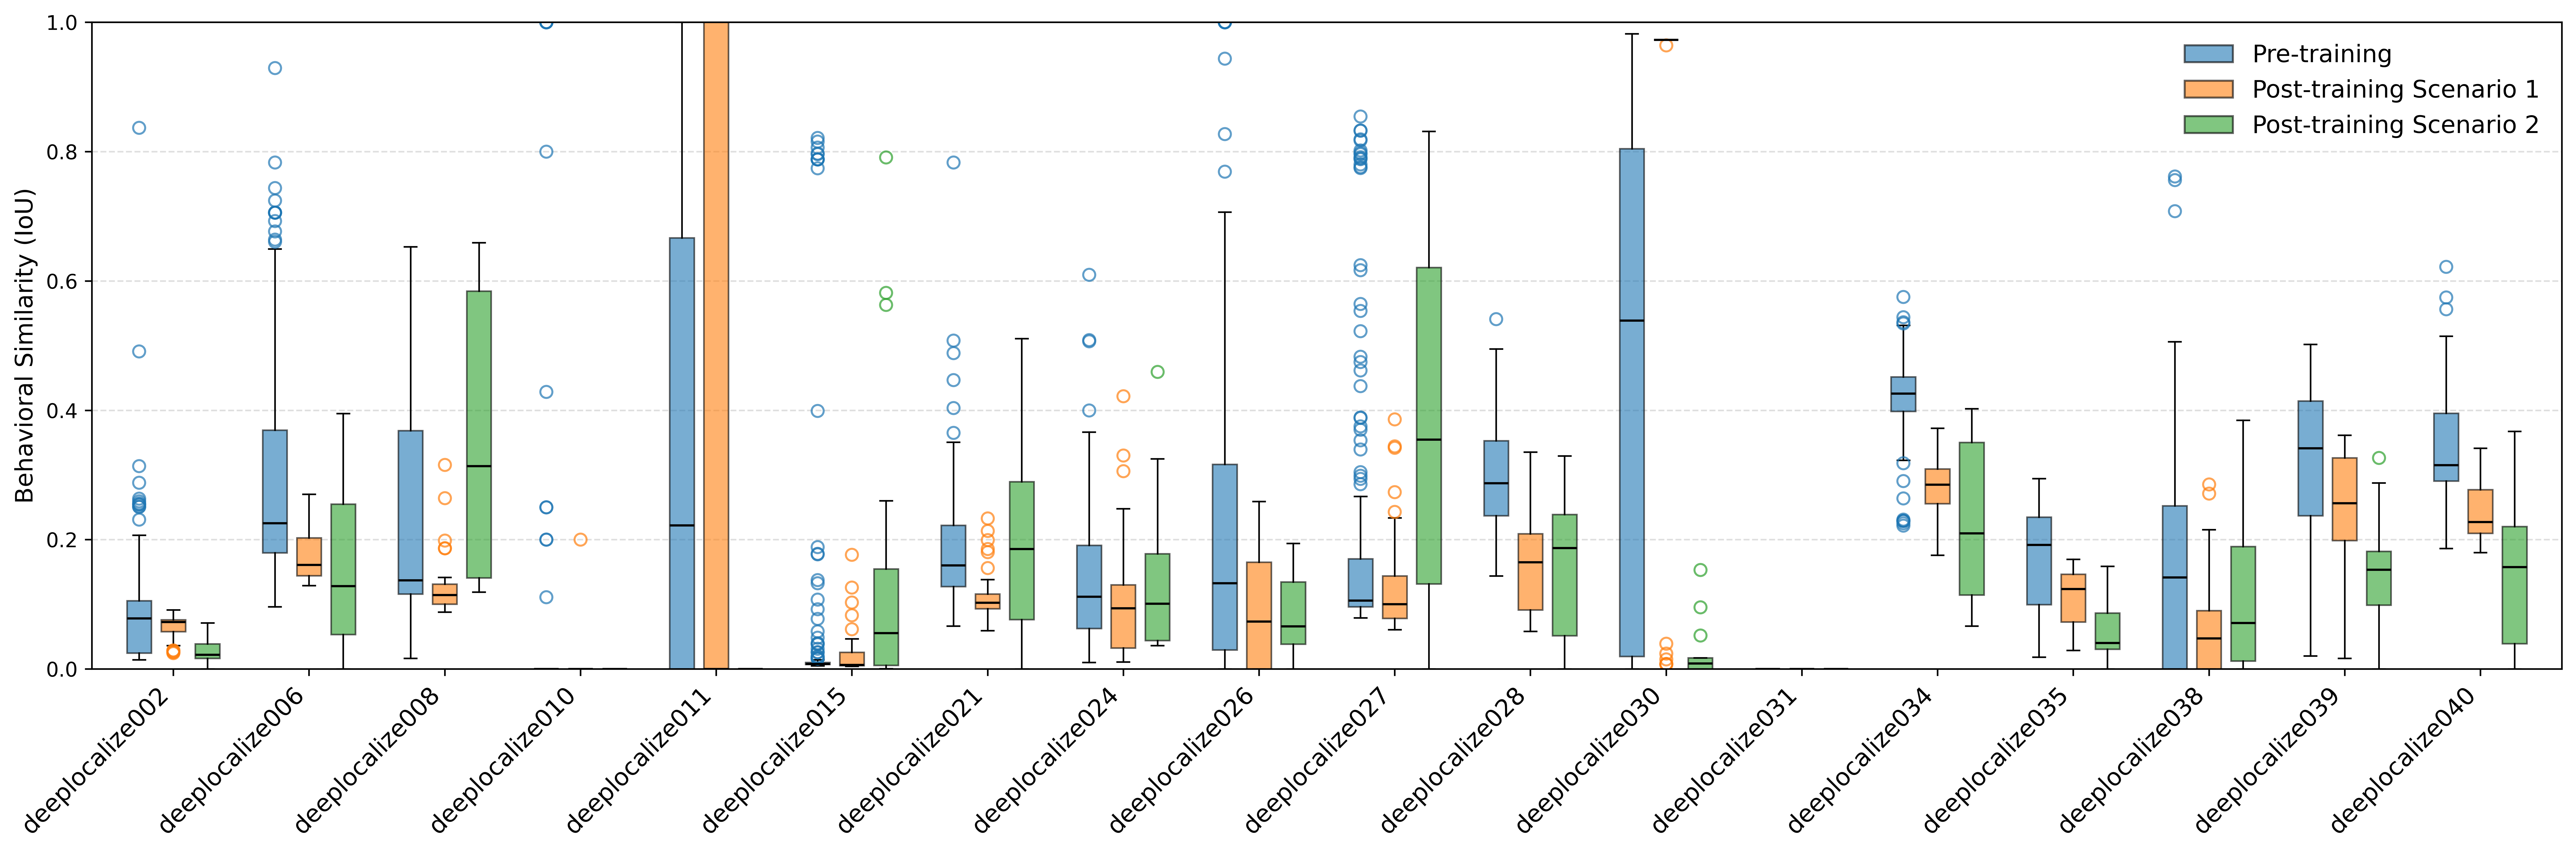

Saved: figures\iou\deeplocalize_iou.pdf


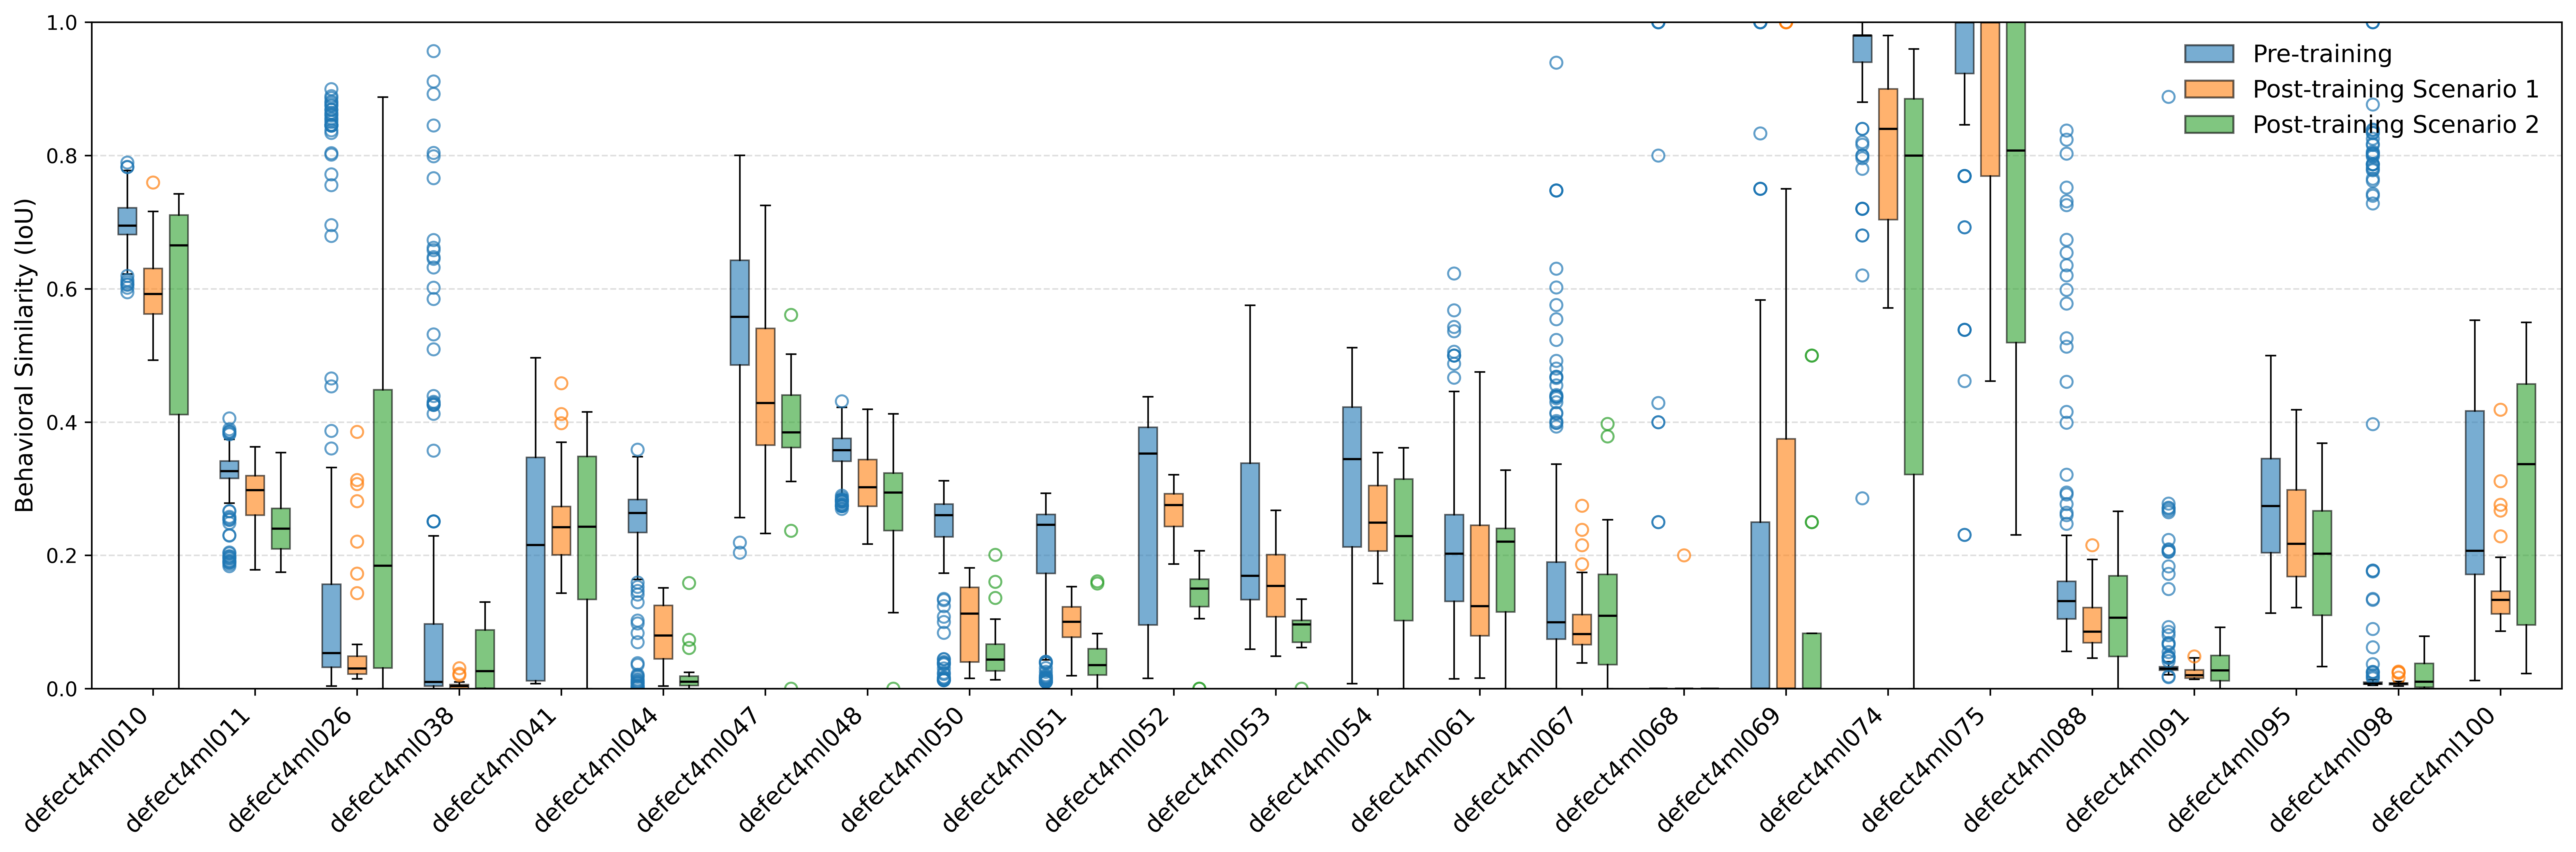

Saved: figures\iou\defect4ml_iou.pdf


In [6]:
# Boxplots of Coupling Strength / IoU per bug with 1–3 scenarios
# Usage (in a notebook):
#   plot_dataset_boxplots(
#       dataset="cleanml",
#       metric="coupling_strength",  # or "iou"
#       mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"],
#       results_dir="results",
#       save_dir="figures"
#   )
#
# Notes:
# - Expects *_clean.csv matrices from quantify_realism.py:
#   results/coupling_strength/coupling_strength_<bug_id>_<suffix>_clean.csv
#   results/detectability_overlap/detectability_overlap_<bug_id>_<suffix>_clean.csv
# - Suffix mapping:
#   pre-training                -> pre_training
#   post-training-scenario1     -> post_training_scenario1_mutants
#   post-training-scenario2     -> post_training_scenario2_mutants

import os
import re
import glob
from typing import List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

DATASET_NAMES = {
       "cleanml": "CleanML",
       "deepfd": "DeepFD",
       "deeplocalize": "DeepLocalize",
       "defect4ml": "defect4ML"
}

SUFFIX_MAP = {
    "pre-training": "pre_training",
    "post-training-scenario1": "post_training_scenario1_mutants",
    "post-training-scenario2": "post_training_scenario2_mutants",
}

# (dir_name, filename_stem)
METRIC_DIR = {
    "coupling_strength": ("coupling_strength", "coupling_strength"),
    "iou": ("detectability_overlap", "detectability_overlap"),
}

# 3 clearly distinct colors
SCENARIO_COLORS = {
    "pre-training": "#1f77b4",           # Blue
    "post-training-scenario1": "#ff7f0e",# Orange
    "post-training-scenario2": "#2ca02c" # Green
}

def _normalize_mutant_types(mutant_types: List[str]) -> List[str]:
    norm = []
    for m in mutant_types:
        key = (m.strip().lower()
               .replace(" ", "")
               .replace("_", "-")
               .replace("pretraining", "pre-training")
               .replace("posttrainingscenario1", "post-training-scenario1")
               .replace("posttrainingscenario2", "post-training-scenario2"))
        if key not in SUFFIX_MAP:
            raise ValueError(f"Unknown mutant type: {m}")
        norm.append(key)
    # preserve order, deduplicate
    seen, ordered = set(), []
    for k in norm:
        if k not in seen:
            ordered.append(k)
            seen.add(k)
    return ordered

def _extract_bug_id_from_path(path: str, filename_stem: str) -> str:
    base = os.path.basename(path)
    core = base.replace("_clean.csv", "")
    if core.startswith(filename_stem + "_"):
        core = core[len(filename_stem) + 1:]
    # core is "<bug_id>_<suffix>"
    bug_id = core.split("_", 1)[0]
    return bug_id

def _numeric_suffix(s: str, dataset: str):
    m = re.search(rf"^{re.escape(dataset)}(\d+)$", s)
    return int(m.group(1)) if m else None

def _numeric_sort_key(bug_id: str, dataset: str):
    n = _numeric_suffix(bug_id, dataset)
    return (0, n) if n is not None else (1, bug_id)

def _find_bugs_for_dataset(dataset: str, metric: str, results_dir: str, suffixes: List[str]) -> List[str]:
    metric_dir, stem = METRIC_DIR[metric]
    folder = os.path.join(results_dir, metric_dir)
    bugs = set()
    for suf in suffixes:
        pattern = os.path.join(folder, f"{stem}_{dataset}*_{suf}_clean.csv")
        for p in glob.glob(pattern):
            bug_id = _extract_bug_id_from_path(p, stem)
            if bug_id.startswith(dataset):
                bugs.add(bug_id)
    return sorted(list(bugs), key=lambda b: _numeric_sort_key(b, dataset))

def _load_flat_values(bug_id: str, metric: str, results_dir: str, suffix: str) -> np.ndarray:
    metric_dir, stem = METRIC_DIR[metric]
    path = os.path.join(results_dir, metric_dir, f"{stem}_{bug_id}_{suffix}_clean.csv")
    if not os.path.exists(path):
        return np.array([])
    df = pd.read_csv(path, index_col=0)
    vals = pd.to_numeric(df.values.flatten(), errors="coerce")
    vals = vals[np.isfinite(vals)]
    return np.clip(vals, 0.0, 1.0)

def plot_dataset_boxplots(
    dataset: str,
    metric: str,
    mutant_types: List[str],
    results_dir: str = "results",
    save_dir: str = "figures",
    figsize=(18, 6),
    box_width=0.18,
    dpi=600
):
    """
    Create a dataset-level boxplot figure with bugs on x-axis and up to three scenario boxes per bug.
    The figure is displayed inline and saved as a PDF.

    Parameters
    ----------
    dataset : str
        Dataset prefix, e.g., "cleanml".
    metric : str
        "coupling_strength" or "iou".
    mutant_types : List[str]
        Any of ["pre-training", "post-training-scenario1", "post-training-scenario2"].
    """
    metric = metric.strip().lower()
    if metric not in METRIC_DIR:
        raise ValueError('metric must be "coupling_strength" or "iou"')

    scenarios = _normalize_mutant_types(mutant_types)
    suffixes = [SUFFIX_MAP[s] for s in scenarios]

    bugs = _find_bugs_for_dataset(dataset, metric, results_dir, suffixes)
    if not bugs:
        raise FileNotFoundError(f"No *_clean.csv files found for dataset '{dataset}' and selected scenarios in {results_dir}.")

    # Collect values per (bug, scenario)
    data_per_scenario: Dict[str, List[np.ndarray]] = {s: [] for s in scenarios}
    missing_counts = {s: 0 for s in scenarios}

    for bug in bugs:
        for s, suf in zip(scenarios, suffixes):
            vals = _load_flat_values(bug, metric, results_dir, suf)
            if vals.size == 0:
                missing_counts[s] += 1
            data_per_scenario[s].append(vals)

    # Figure
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = plt.gca()
    ax.set_ylim(0.0, 1.0)
    ax.set_ylabel("Coupling Strength (CS)" if metric == "coupling_strength" else "Behavioral Similarity (IoU)", fontsize=12)

    x_positions = np.arange(len(bugs), dtype=float)
    offsets_map = {
        1: [0.0],
        2: [-box_width/1.2, box_width/1.2],
        3: [-box_width*1.4, 0.0, box_width*1.4],
    }
    offsets = offsets_map[len(scenarios)]

    legend_handles, legend_labels = [], []

    # Draw boxes per scenario with distinct colors
    for i, s in enumerate(scenarios):
        positions = x_positions + offsets[i]
        bp = ax.boxplot(
            data_per_scenario[s],
            positions=positions,
            widths=box_width,
            patch_artist=True,
            manage_ticks=False,
            showfliers=True,
        )

###########################################################################
        # === Annotate sample size per box (n) ===
        # Annotate sample size inside each box (centered, rotated)
        #for pos, vals in zip(positions, data_per_scenario[s]):
         #   n = len(vals)
          #  if n == 0:
           #     continue
            #median_val = np.median(vals) + 0.08
            #ax.text(
             #   pos, median_val, f"n={n}",
              #  ha='center', va='center',
               # fontsize=7, rotation=90, color='black'
            #)
        # === END ===
###########################################################################
        
        color = SCENARIO_COLORS.get(s, None)
        # color the box + median + whiskers/caps subtly (edges)
        for box in bp["boxes"]:
            box.set_facecolor(color)
            box.set_alpha(0.6)
            box.set_edgecolor("black")
            box.set_linewidth(0.8)
        for median in bp["medians"]:
            median.set_color("black")
            median.set_linewidth(1.1)
        for whisker in bp["whiskers"]:
            whisker.set_color("black")
            whisker.set_linewidth(0.8)
        for cap in bp["caps"]:
            cap.set_color("black")
            cap.set_linewidth(0.8)
        for flier in bp["fliers"]:
            flier.set_markeredgecolor(color)
            flier.set_alpha(0.7)

        legend_handles.append(Patch(facecolor=color, alpha=0.6, edgecolor="black"))
        
        # Custom formatting for full scenario names
        if s == "pre-training":
            legend_labels.append("Pre-training")
        elif s == "post-training-scenario1":
            legend_labels.append("Post-training Scenario 1")
        elif s == "post-training-scenario2":
            legend_labels.append("Post-training Scenario 2")
        else:
            legend_labels.append(s.replace("-", " ").title())

    ax.set_xticks(x_positions)
    ax.set_xticklabels(bugs, rotation=45, ha="right", fontsize=12)
    ax.set_xlim(-0.6, len(bugs)-0.4)
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    title_metric = "Coupling Strength (CS)" if metric == "coupling_strength" else "Behavioral Similarity (IoU)"
    #ax.set_title(f"{dataset.upper()}: {title_metric} per Bug", fontsize=13, pad=10)
    #ax.set_title(f"{DATASET_NAMES.get(dataset, dataset)}: {title_metric} per Bug", fontsize=13, pad=10)
    if legend_handles:
        ax.legend(legend_handles, legend_labels, loc="upper right", fontsize=12, frameon=False)

    # Log missing files (won't block plotting)
    for s in scenarios:
        if missing_counts[s]:
            print(f"[warn] Missing {missing_counts[s]} file(s) for scenario '{s}'.")

    # Save
    os.makedirs(os.path.join(save_dir, metric), exist_ok=True)
    # add bug-range to filename for traceability
    first_num = _numeric_suffix(bugs[0], dataset)
    last_num = _numeric_suffix(bugs[-1], dataset)
    bug_range = f"{bugs[0]}-to-{bugs[-1]}" if first_num is None or last_num is None else f"{dataset}{first_num:03d}-to-{dataset}{last_num:03d}"
    scen_code = "+".join([s.replace("-", "") for s in scenarios])
    # simple filename
    out_path = os.path.join(save_dir, metric, f"{dataset}_{metric}.pdf")


    plt.tight_layout()
    plt.savefig(out_path)   # PDF
    plt.show()              # Display in cell
    plt.close(fig)

    print(f"Saved: {out_path}")

plot_dataset_boxplots(dataset="cleanml", metric="coupling_strength",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="deepfd", metric="coupling_strength",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="deeplocalize", metric="coupling_strength",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="defect4ml", metric="coupling_strength",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="cleanml", metric="iou",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="deepfd", metric="iou",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="deeplocalize", metric="iou",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

plot_dataset_boxplots(dataset="defect4ml", metric="iou",
                      mutant_types=["pre-training", "post-training-scenario1", "post-training-scenario2"])

Processing data from _clean.csv files...

Coupling Strength:
  Found 258 _clean.csv files in coupling_strength
  Unique bug-scenario combinations: 258
    CleanML: 19 unique bugs
      - 19 bugs with all 3 scenarios
    DeepFD: 25 unique bugs
      - 25 bugs with all 3 scenarios
    DeepLocalize: 18 unique bugs
      - 18 bugs with all 3 scenarios
    defect4ML: 24 unique bugs
      - 24 bugs with all 3 scenarios

Debug: Checking data availability per bug...
  CleanML: 19 bugs, 0 with partial data, 0 ties resolved by priority
  DeepFD: 25 bugs, 0 with partial data, 7 ties resolved by priority
  DeepLocalize: 18 bugs, 0 with partial data, 2 ties resolved by priority
  defect4ML: 24 bugs, 0 with partial data, 3 ties resolved by priority

Behavioral Similarity (IoU):
  Found 258 _clean.csv files in detectability_overlap
  Unique bug-scenario combinations: 258
    CleanML: 19 unique bugs
      - 19 bugs with all 3 scenarios
    DeepFD: 25 unique bugs
      - 25 bugs with all 3 scenarios
  

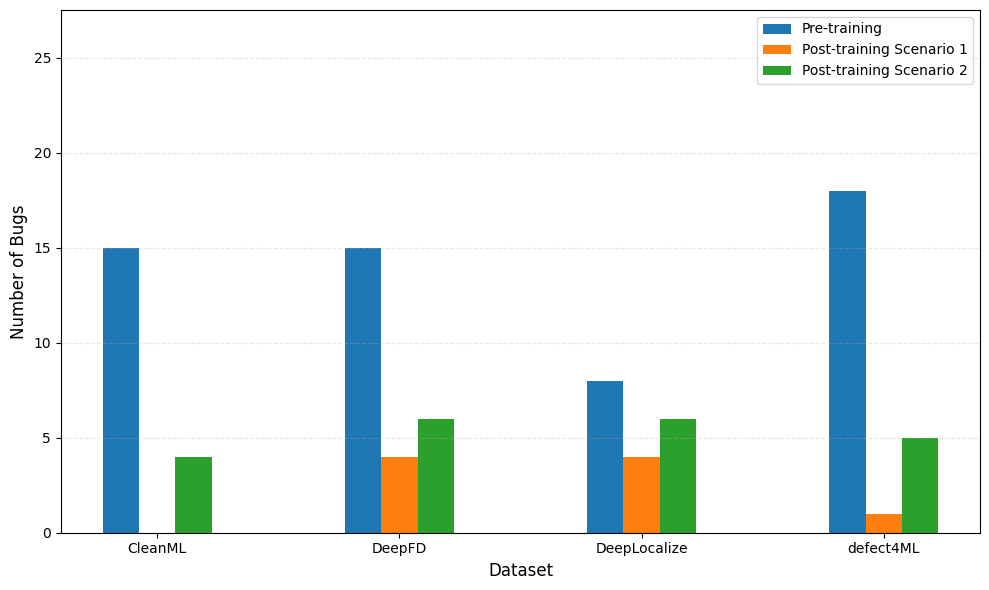

Saved IoU chart to: figures/win_counts_IoU.pdf


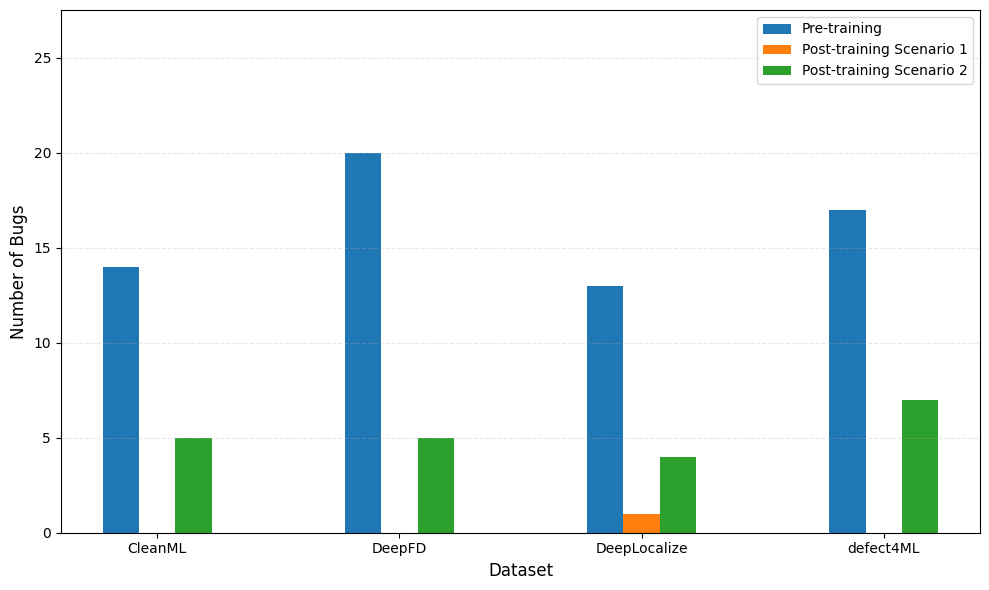


WIN COUNT SUMMARY

Coupling Strength (CS):
Scenario      Post-training Scenario 1  Post-training Scenario 2  Pre-training
Dataset                                                                       
CleanML                              0                         4            15
DeepFD                               4                         6            15
DeepLocalize                         4                         6             8
defect4ML                            1                         5            18

Total wins per dataset (should equal number of bugs):
  CleanML: 19
  DeepFD: 25
  DeepLocalize: 18
  defect4ML: 24

Behavioral Similarity (IoU):
Scenario      Post-training Scenario 1  Post-training Scenario 2  Pre-training
Dataset                                                                       
CleanML                              0                         5            14
DeepFD                               0                         5            20
DeepLocalize       

In [79]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
RESULTS_ROOT = 'results/'  # Adjust this path
OUTPUT_DIR = 'figures/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Define mappings
SCENARIOS = {
    'pre_training': 'Pre-training',
    'post_training_scenario1_mutants': 'Post-training Scenario 1',
    'post_training_scenario2_mutants': 'Post-training Scenario 2'
}

DATASETS = {
    'cleanml': 'CleanML',
    'deepfd': 'DeepFD',
    'deeplocalize': 'DeepLocalize',
    'defect4ml': 'defect4ML'
}

def parse_filename(filename):
    """Extract dataset, bug_id, and scenario from filename."""
    base = os.path.basename(filename)
    
    # Remove prefix and extension
    if 'coupling_strength_' in base:
        core = base.replace('coupling_strength_', '').replace('_clean.csv', '').replace('.csv', '')
    elif 'detectability_overlap_' in base:
        core = base.replace('detectability_overlap_', '').replace('_clean.csv', '').replace('.csv', '')
    else:
        return None, None, None
    
    # Extract components
    parts = core.split('_')
    bug_id = parts[0]
    
    # Find dataset
    dataset = None
    for key in DATASETS:
        if bug_id.startswith(key):
            dataset = key
            break
    
    if not dataset:
        return None, None, None
    
    # Determine scenario
    scenario_part = '_'.join(parts[1:])
    scenario = SCENARIOS.get(scenario_part)
    
    return dataset, bug_id, scenario

def read_median_from_clean_csv(filepath):
    """Read _clean.csv file and calculate median of all numeric values."""
    try:
        df = pd.read_csv(filepath, index_col=0)
        # These files contain just the numeric values
        values = df.values.flatten()
        values = values[~np.isnan(values)]
        return np.median(values) if len(values) > 0 else np.nan
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        return np.nan

def collect_data(metric_dir, metric_name):
    """Collect median values for all bugs from _clean.csv files."""
    data = []
    
    # Only look for _clean.csv files
    pattern = os.path.join(metric_dir, '*_clean.csv')
    files = glob.glob(pattern)
    
    print(f"  Found {len(files)} _clean.csv files in {os.path.basename(metric_dir)}")
    
    # Track unique bug-scenario combinations to avoid duplicates
    seen_combinations = set()
    
    for filepath in files:
        dataset, bug_id, scenario = parse_filename(filepath)
        
        if dataset and scenario:
            # Check if we've already seen this bug-scenario combination
            combination = (bug_id, scenario)
            if combination in seen_combinations:
                print(f"    Warning: Duplicate found for {bug_id} - {scenario}, skipping...")
                continue
            
            seen_combinations.add(combination)
            
            median_val = read_median_from_clean_csv(filepath)
            if not np.isnan(median_val):
                data.append({
                    'Dataset': DATASETS[dataset],
                    'Bug': bug_id,
                    'Scenario': scenario,
                    'Median': median_val
                })
    
    df = pd.DataFrame(data)
    
    # Debug: Show unique bugs per dataset and scenarios
    print(f"  Unique bug-scenario combinations: {len(seen_combinations)}")
    for ds in df['Dataset'].unique():
        ds_df = df[df['Dataset'] == ds]
        bugs_in_ds = ds_df['Bug'].unique()
        print(f"    {ds}: {len(bugs_in_ds)} unique bugs")
        
        # Check how many scenarios each bug has
        complete_bugs = 0
        for bug in bugs_in_ds:
            bug_scenarios = len(ds_df[ds_df['Bug'] == bug])
            if bug_scenarios == 3:
                complete_bugs += 1
        print(f"      - {complete_bugs} bugs with all 3 scenarios")
    
    return df

def calculate_wins(df):
    """Count wins per scenario for each dataset - exactly one win per bug.
    In case of ties, priority is given to Pre-training scenario."""
    results = []
    
    # Define priority order for tie-breaking (Pre-training gets highest priority)
    scenario_priority = {
        'Pre-training': 1,
        'Post-training Scenario 1': 2,
        'Post-training Scenario 2': 3
    }
    
    # Debug information
    print("\nDebug: Checking data availability per bug...")
    
    for dataset in df['Dataset'].unique():
        dataset_df = df[df['Dataset'] == dataset]
        
        # Initialize win counts for this dataset
        wins = {s: 0 for s in SCENARIOS.values()}
        
        # Get unique bugs in this dataset
        bugs = dataset_df['Bug'].unique()
        
        ties_resolved = 0
        bugs_with_partial_data = 0
        
        for bug in bugs:
            bug_df = dataset_df[dataset_df['Bug'] == bug]
            
            # Collect median values for all scenarios for this bug
            scenario_medians = {}
            for scenario in SCENARIOS.values():
                scenario_row = bug_df[bug_df['Scenario'] == scenario]
                if not scenario_row.empty:
                    scenario_medians[scenario] = scenario_row['Median'].values[0]
            
            # Check if we have partial data
            if len(scenario_medians) < len(SCENARIOS):
                bugs_with_partial_data += 1
            
            # Only count if we have data for this bug
            if scenario_medians:
                # Find the maximum median value
                max_median = max(scenario_medians.values())
                
                # Find all scenarios with the maximum value
                winning_scenarios = [s for s, v in scenario_medians.items() 
                                   if np.isclose(v, max_median, rtol=1e-9)]
                
                if len(winning_scenarios) > 1:
                    # Tie detected - give win to highest priority scenario
                    ties_resolved += 1
                    winner = min(winning_scenarios, key=lambda x: scenario_priority[x])
                    wins[winner] += 1
                else:
                    # Single winner gets the point
                    wins[winning_scenarios[0]] += 1
        
        print(f"  {dataset}: {len(bugs)} bugs, {bugs_with_partial_data} with partial data, {ties_resolved} ties resolved by priority")
        
        # Store results for this dataset
        for scenario, count in wins.items():
            results.append({
                'Dataset': dataset,
                'Scenario': scenario,
                'Wins': int(count)  # Convert to int since no more fractional wins
            })
    
    return pd.DataFrame(results)

# Process data
print("Processing data from _clean.csv files...")
print("\nCoupling Strength:")
cs_dir = os.path.join(RESULTS_ROOT, 'coupling_strength')
cs_data = collect_data(cs_dir, 'CS')

cs_wins = calculate_wins(cs_data)
cs_wins['Metric'] = 'Coupling Strength (CS)'

print("\nBehavioral Similarity (IoU):")
iou_dir = os.path.join(RESULTS_ROOT, 'detectability_overlap')
iou_data = collect_data(iou_dir, 'IoU')

iou_wins = calculate_wins(iou_data)
iou_wins['Metric'] = 'Detectability Overlap (IoU)'

# Verify totals
print("\nVerifying win counts (should equal number of bugs per dataset):")
for metric_wins, metric_name in [(cs_wins, 'CS'), (iou_wins, 'IoU')]:
    print(f"\n{metric_name}:")
    for dataset in metric_wins['Dataset'].unique():
        dataset_wins = metric_wins[metric_wins['Dataset'] == dataset]
        total = dataset_wins['Wins'].sum()
        print(f"  {dataset}: {total} total wins")

# Create and display plots one after the other
# First plot: Coupling Strength
fig1, ax1 = plt.subplots(figsize=(10, 6))

datasets_order = ['CleanML', 'DeepFD', 'DeepLocalize', 'defect4ML']
datasets = [d for d in datasets_order if d in cs_wins['Dataset'].unique()]
scenarios = ['Pre-training', 'Post-training Scenario 1', 'Post-training Scenario 2']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Green, Orange

x = np.arange(len(datasets))
width = 0.5

for i, (scenario, color) in enumerate(zip(scenarios, colors)):
    wins = []
    for dataset in datasets:
        row = cs_wins[(cs_wins['Dataset'] == dataset) & 
                     (cs_wins['Scenario'] == scenario)]
        wins.append(row['Wins'].values[0] if not row.empty else 0)
    ax1.bar(x + (i-1)*width, wins, width, label=scenario, color=color)

ax1.set_xlabel('Dataset', fontsize=12)
ax1.set_ylabel('Number of Bugs', fontsize=12)
#ax1.set_title('Bug-wise Winners: Median Coupling Strength (CS) Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(datasets)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
y_max = max([w for w in cs_wins['Wins']] + [25])
ax1.set_ylim(0, y_max * 1.1)

plt.tight_layout()
cs_output_file = os.path.join(OUTPUT_DIR, 'win_counts_CS.pdf')
plt.savefig(cs_output_file, dpi=600, bbox_inches='tight')
print(f"\nSaved CS chart to: {cs_output_file}")
plt.show()

# Second plot: Detectability Overlap
fig2, ax2 = plt.subplots(figsize=(10, 6))

datasets = [d for d in datasets_order if d in iou_wins['Dataset'].unique()]
x = np.arange(len(datasets))  

for i, (scenario, color) in enumerate(zip(scenarios, colors)):
    wins = []
    for dataset in datasets:
        row = iou_wins[(iou_wins['Dataset'] == dataset) & 
                      (iou_wins['Scenario'] == scenario)]
        wins.append(row['Wins'].values[0] if not row.empty else 0)
    ax2.bar(x + (i-1)*width, wins, width, label=scenario, color=color)

ax2.set_xlabel('Dataset', fontsize=12)
ax2.set_ylabel('Number of Bugs', fontsize=12)
#ax2.set_title('Bug-wise Winners: Median Behavioral Similarity (IoU) Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(datasets)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
y_max = max([w for w in iou_wins['Wins']] + [25])
ax2.set_ylim(0, y_max * 1.1)

plt.tight_layout()
iou_output_file = os.path.join(OUTPUT_DIR, 'win_counts_IoU.pdf')
plt.savefig(iou_output_file, dpi=600, bbox_inches='tight')
print(f"Saved IoU chart to: {iou_output_file}")
plt.show()

# Print detailed summary
print("\n" + "="*60)
print("WIN COUNT SUMMARY")
print("="*60)

for metric_wins, metric_name in [(cs_wins, 'Coupling Strength (CS)'), 
                                  (iou_wins, 'Behavioral Similarity (IoU)')]:
    print(f"\n{metric_name}:")
    pivot = metric_wins.pivot(index='Dataset', columns='Scenario', values='Wins')
    print(pivot.to_string())
    
    # Verify totals
    print(f"\nTotal wins per dataset (should equal number of bugs):")
    for dataset in pivot.index:
        total = pivot.loc[dataset].sum()
        print(f"  {dataset}: {int(total)}")

print(f"\nAll charts saved to: {OUTPUT_DIR}")
